In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tqdm

import holodeck as holo
from holodeck import utils, plot
from holodeck.constants import YR

mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
def run_single_params_model(space, params, fobs_edges, nreals=100, nloudest=5):
    param_names = space.param_names
    log = space._log
    
    pars = {name: params[pp] for pp, name in enumerate(param_names)}

    log.info(f"Loading sam and hard from {params=}")
    sam, hard = space.model_for_params(pars, sam_shape=space.sam_shape)

    fobs_cents = utils.midpoints(fobs_edges, log=False)
    fobs_orb_edges = fobs_edges / 2.0
    fobs_orb_cents = fobs_cents / 2.0

    log.info(f"Calculating `dynamic_binary_number` for {fobs_cents.size} freqs")
    edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents)
    edges[-1] = fobs_orb_edges

    # integrate for number
    log.debug(f"integrating to get number of binaries")
    number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
    number = number * np.diff(np.log(fobs_edges))

    log.debug(f"calculating strains and sources for shape ({fobs_cents.size}, {nreals}), {nloudest=}")
    hc_ss, hc_bg, sspar, bgpar = holo.single_sources.ss_gws(
        edges, number, realize=nreals, loudest=nloudest, params=True
    )

    # use_redz = sam._redz_final
    # gwb = holo.gravwaves._gws_from_number_grid_integrated(edges, use_redz, number, nreals)

    gwb = holo.gravwaves._gws_from_number_grid_integrated(edges, number, nreals)

    data = dict(
        fobs=fobs_cents, fobs_edges=fobs_edges,
        gwb=gwb, hc_ss=hc_ss, hc_bg=hc_bg, sspar=sspar, bgpar=bgpar
    )
    return data


def run_params_subspace(space, params, fobs_edges, **kwargs):
    log = space._log
    param_names = space.param_names
    npars = len(param_names)
    params = np.asarray(params)

    # Make sure shapes look good
    if params.ndim != 2 or params.shape[1] != npars:
        err = f"`params` shape {np.shape(params)} does not match {npars} parameters: {param_names}!"
        log.exception(err)
        raise RuntimeError(err)

    # Make sure all parameters are within excepted bounds
    for pp, name in enumerate(param_names):
        dist = space._dists[pp]

        bads = (params[:, pp] <= dist.extrema[0]) | (dist.extrema[1] <= params[:, pp])
        if np.any(bads):
            err = f"`params` {pp} {name} are outside of extrema [{dist.extrema[0]:.8e}, {dist.extrema[1]:.8e}]!"
            err += f"  {utils.stats(params[:, pp])}"
            log.exception(err)
            raise ValueError(err)

    num_samps = params.shape[0]

    all_data = []
    for ii in tqdm.trange(num_samps):
        data = run_single_params_model(space, params[ii], fobs_edges, **kwargs)
        all_data.append(data)

    return all_data


NUM_FBINS = 14
PTA_DUR = 16.03     # [yrs]
SHAPE = 40
NREALS = 50

space_class = holo.param_spaces.PS_Broad_Uniform_02B
space = space_class(holo.log, 0, SHAPE, None)

dur = PTA_DUR * YR
pta_cad = dur / (2 * NUM_FBINS)
fobs_edges = holo.utils.nyquist_freqs_edges(dur, pta_cad)

draw_params = [
    [ 4.57784231, -1.51291368, 10.90450461,  8.85735088,  0.52998213],
    [ 6.96691128, -2.38054765, 11.08484247,  9.29421616,  0.45471499],
    [ 0.37454247, -2.10501603, 11.62087475,  8.84882612,  0.09778727]
]

# Run full set of `draw_params`
# all_data = run_params_subspace(space, draw_params[:4], fobs_edges, nreals=NREALS)

single_data = run_single_params_model(space, draw_params[0], fobs_edges, nreals=NREALS)


19:42:57 INFO : Loading sam and hard from params=[4.57784231, -1.51291368, 10.90450461, 8.85735088, 0.52998213] [2167385378.py:run_single_params_model]
19:42:57 WARNING : class `Fixed_Time` has been deprecated!  Please use `Fixed_Time_2PL` with new parametrization! [hardening.py:__init__]
19:42:57 INFO : calculating normalization exactly [hardening.py:__init__]
19:43:05 INFO : Calculating `dynamic_binary_number` for 14 freqs [2167385378.py:run_single_params_model]
19:43:05 INFO : zero_coalesced=False, zero_stalled=True [sam.py:dynamic_binary_number]
19:43:05 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
19:43:05 INFO : Adding MMbulge scatter (5.2998e-01) [sam.py:static_binary_density]
19:43:05 INFO : 	dens bef: (0.00e+00, 2.28e-273, 1.31e-51, 2.01e-04, 1.54e-02, 7.61e-02, 4.57e-01) [sam.py:static_binary_density]
19:43:06 INFO : Scatter added after 0.898399 sec [sam.py:static_binary_density]
19:43:06 INFO : 	dens aft: (3.38e-20, 4.70e-

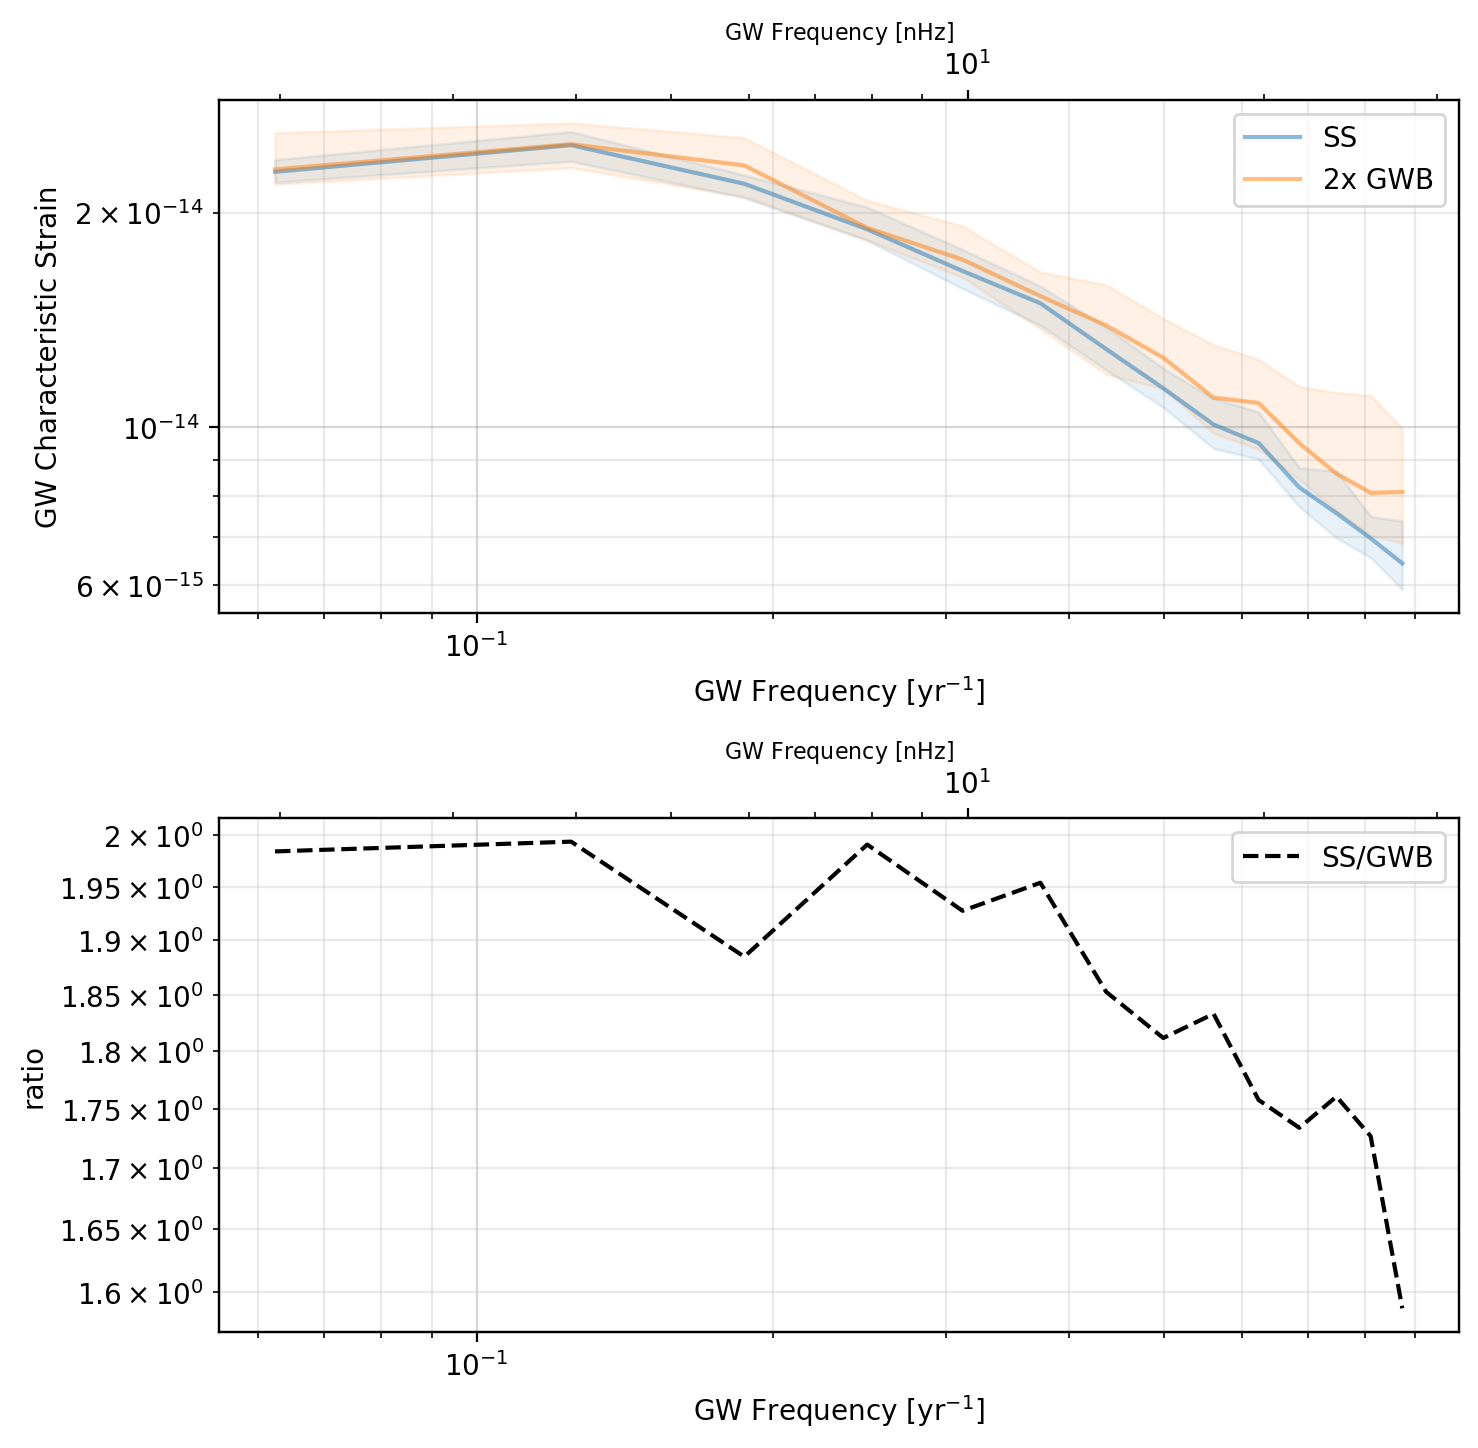

In [3]:
fig, axes = plot.figax(
    figsize=[8, 8], nrows=2, hspace=0.4,
    xlabel=plot.LABEL_GW_FREQUENCY_YR, ylabel=plot.LABEL_CHARACTERISTIC_STRAIN
)


xx = single_data['fobs'] * YR

# y1 = data['hc_bg']
y1 = np.sqrt(np.sum(single_data['hc_bg'][:, :, np.newaxis]**2 + single_data['hc_ss']**2, axis=-1))
y2 = single_data['gwb']

labels = ['SS', '2x GWB']
for jj, yy in enumerate([y1, 2*y2]):
    med, *conf = np.percentile(yy, [50, 25, 75], axis=-1)
    cc, = axes[0].plot(xx, med, alpha=0.5, label=labels[jj])
    cc = cc.get_color()
    axes[0].fill_between(xx, *conf, color=cc, alpha=0.1)

axes[1].plot(xx, np.median(y1, axis=-1)/np.median(y2, axis=-1), 'k--', label='SS/GWB')
        

axes[1].set_ylabel('ratio')
for ax in axes:
    ax.legend()
    plot._twin_hz(ax)
    
plt.show()

In [2]:
def run_single_params_model_new(space, params, fobs_edges, nreals=100, nloudest=5):
    param_names = space.param_names
    log = space._log
    
    pars = {name: params[pp] for pp, name in enumerate(param_names)}

    log.info(f"Loading sam and hard from {params=}")
    sam, hard = space.model_for_params(pars, sam_shape=space.sam_shape)

    fobs_cents = utils.midpoints(fobs_edges, log=False)
    fobs_orb_edges = fobs_edges / 2.0
    fobs_orb_cents = fobs_cents / 2.0

    # log.info(f"Calculating `dynamic_binary_number` for {fobs_cents.size} freqs")
    # edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents)
    # edges[-1] = fobs_orb_edges

    # # integrate for number
    # log.debug(f"integrating to get number of binaries")
    # number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
    # number = number * np.diff(np.log(fobs_edges))

    log.debug(f"calculating strains and sources for shape ({fobs_cents.size}, {nreals}), {nloudest=}")
    hc_ss, hc_bg, sspar, bgpar = sam.ss_gwb(fobs_edges, hard=hard, realize=nreals, loudest=nloudest, params=True)

    # use_redz = sam._redz_final
    # gwb = holo.gravwaves._gws_from_number_grid_integrated(edges, use_redz, number, nreals)

    gwb = sam.gwb(fobs_edges, hard=hard, realize=nreals)

    data = dict(
        fobs=fobs_cents, fobs_edges=fobs_edges,
        gwb=gwb, hc_ss=hc_ss, hc_bg=hc_bg, sspar=sspar, bgpar=bgpar
    )
    return data


def run_params_subspace(space, params, fobs_edges, **kwargs):
    log = space._log
    param_names = space.param_names
    npars = len(param_names)
    params = np.asarray(params)

    # Make sure shapes look good
    if params.ndim != 2 or params.shape[1] != npars:
        err = f"`params` shape {np.shape(params)} does not match {npars} parameters: {param_names}!"
        log.exception(err)
        raise RuntimeError(err)

    # Make sure all parameters are within excepted bounds
    for pp, name in enumerate(param_names):
        dist = space._dists[pp]

        bads = (params[:, pp] <= dist.extrema[0]) | (dist.extrema[1] <= params[:, pp])
        if np.any(bads):
            err = f"`params` {pp} {name} are outside of extrema [{dist.extrema[0]:.8e}, {dist.extrema[1]:.8e}]!"
            err += f"  {utils.stats(params[:, pp])}"
            log.exception(err)
            raise ValueError(err)

    num_samps = params.shape[0]

    all_data = []
    for ii in tqdm.trange(num_samps):
        data = run_single_params_model(space, params[ii], fobs_edges, **kwargs)
        all_data.append(data)

    return all_data


NUM_FBINS = 14
PTA_DUR = 16.03     # [yrs]
SHAPE = 40
NREALS = 50

space_class = holo.param_spaces.PS_Broad_Uniform_02B
space = space_class(holo.log, 0, SHAPE, None)

dur = PTA_DUR * YR
pta_cad = dur / (2 * NUM_FBINS)
fobs_edges = holo.utils.nyquist_freqs_edges(dur, pta_cad)

draw_params = [
    [ 4.57784231, -1.51291368, 10.90450461,  8.85735088,  0.52998213],
    [ 6.96691128, -2.38054765, 11.08484247,  9.29421616,  0.45471499],
    [ 0.37454247, -2.10501603, 11.62087475,  8.84882612,  0.09778727]
]

# Run full set of `draw_params`
# all_data = run_params_subspace(space, draw_params[:4], fobs_edges, nreals=NREALS)

single_data = run_single_params_model_new(space, draw_params[0], fobs_edges, nreals=NREALS)


19:48:24 INFO : Loading sam and hard from params=[4.57784231, -1.51291368, 10.90450461, 8.85735088, 0.52998213] [1447586233.py:run_single_params_model_new]
19:48:24 WARNING : class `Fixed_Time` has been deprecated!  Please use `Fixed_Time_2PL` with new parametrization! [hardening.py:__init__]
19:48:24 INFO : calculating normalization exactly [hardening.py:__init__]
SS 1: 
Current memory usage: max=0.30 GB, RSS=0.30 GB, VMS=391.17 GB
19:48:32 INFO : zero_coalesced=False, zero_stalled=True [sam.py:dynamic_binary_number]
19:48:32 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
19:48:32 INFO : Adding MMbulge scatter (5.2998e-01) [sam.py:static_binary_density]
19:48:32 INFO : 	dens bef: (0.00e+00, 2.28e-273, 1.31e-51, 2.01e-04, 1.54e-02, 7.61e-02, 4.57e-01) [sam.py:static_binary_density]
19:48:33 INFO : Scatter added after 0.89408 sec [sam.py:static_binary_density]
19:48:33 INFO : 	dens aft: (3.38e-20, 4.70e-10, 5.18e-07, 1.81e-03, 3.38e-02,

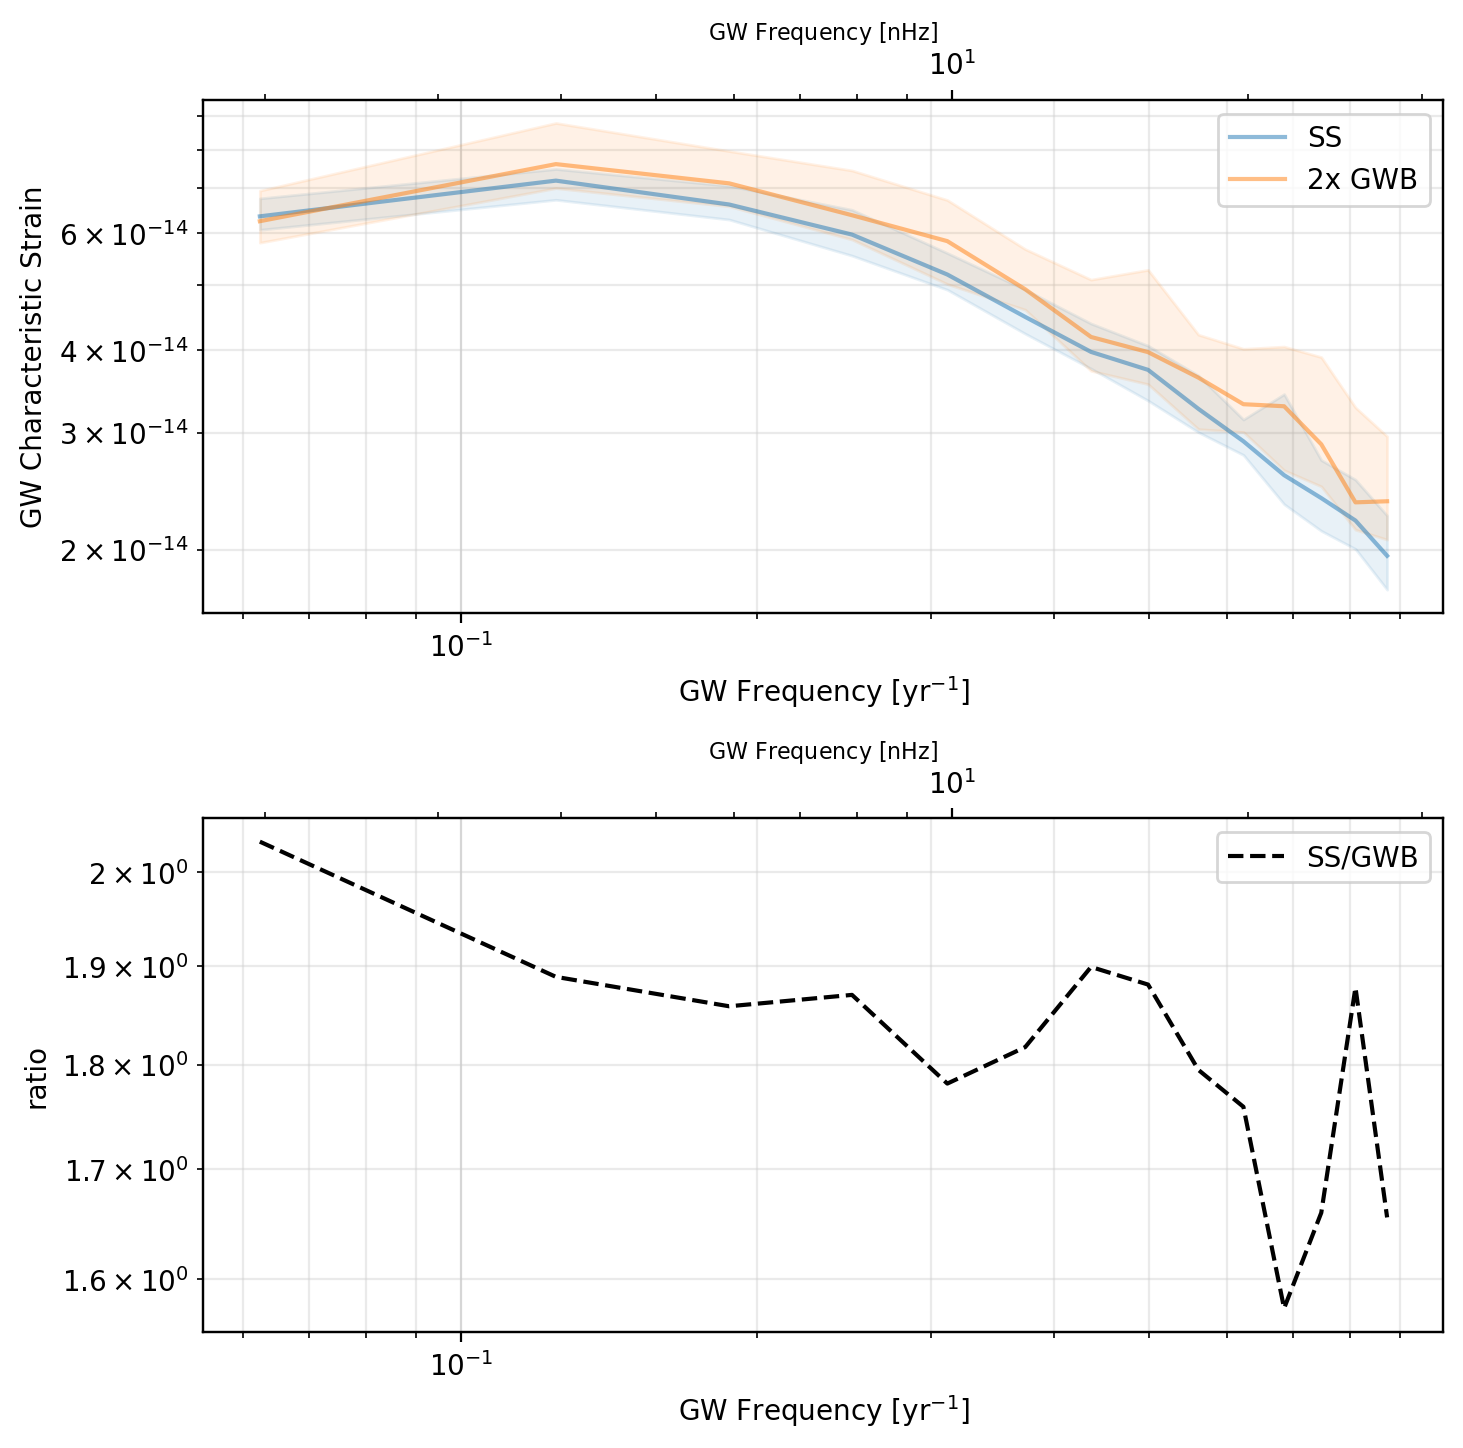

In [3]:
fig, axes = plot.figax(
    figsize=[8, 8], nrows=2, hspace=0.4,
    xlabel=plot.LABEL_GW_FREQUENCY_YR, ylabel=plot.LABEL_CHARACTERISTIC_STRAIN
)


xx = single_data['fobs'] * YR

# y1 = data['hc_bg']
y1 = np.sqrt(np.sum(single_data['hc_bg'][:, :, np.newaxis]**2 + single_data['hc_ss']**2, axis=-1))
y2 = single_data['gwb']

labels = ['SS', '2x GWB']
for jj, yy in enumerate([y1, 2*y2]):
    med, *conf = np.percentile(yy, [50, 25, 75], axis=-1)
    cc, = axes[0].plot(xx, med, alpha=0.5, label=labels[jj])
    cc = cc.get_color()
    axes[0].fill_between(xx, *conf, color=cc, alpha=0.1)

axes[1].plot(xx, np.median(y1, axis=-1)/np.median(y2, axis=-1), 'k--', label='SS/GWB')
        

axes[1].set_ylabel('ratio')
for ax in axes:
    ax.legend()
    plot._twin_hz(ax)
    
plt.show()